In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Not really needed, but nicer plots
import seaborn as sns
sns.set()      
sns.set_context("talk")

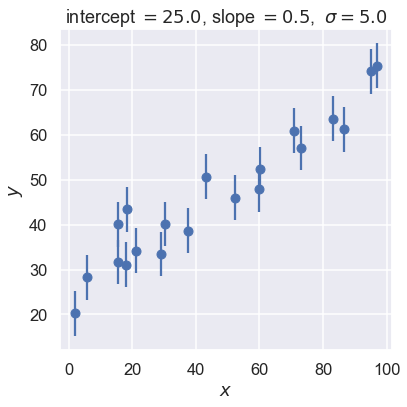

In [2]:
def make_data(intercept, slope, N=20, dy=5, rseed=42):
    """Given a straight line defined by intercept and slope:
          y = slope * x + intercept
       generate N points randomly spaced points from x=0 to x=100
       with Gaussian (i.e., normal) error with mean zero and standard
       deviation dy.
       
       Return the x and y arrays and an array of standard deviations.
    """
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N)
    return x, y, dy * np.ones_like(x)

intercept = 25.
slope = 0.5

theta_true = [intercept, slope]
x, y, dy = make_data(*theta_true)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, dy, fmt='o')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plot_title = rf'intercept $= {intercept:.1f}$, slope $= {slope:.1f}$, ' \
              + rf' $\sigma = {dy[0]:.1f}$'
ax.set_title(plot_title)
fig.tight_layout()

In [3]:
# Write your code here

In [4]:
def log_likelihood(theta, x, y, dy):
    """ 
    Return the log of the likelihood function, given a 2D array theta of
    parameters (b, m) and the x, y coordinates with standard deviation dy.
    """
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy**2) + (y - y_model)**2 / dy**2)

In [5]:
from scipy import optimize

def minfunc(theta, x, y, dy):
    """
    Function to be minimized: minus the logarithm of the likelihood.
    """
    return -log_likelihood(theta, x, y, dy)

result = optimize.minimize(minfunc, x0=[0, 0], args=(x, y, dy))

with np.printoptions(precision=3, suppress=True):
    print(f' MLE: {result.x}')
    print(f'True:  {theta_true}')

 MLE: [24.818  0.474]
True:  [25.0, 0.5]


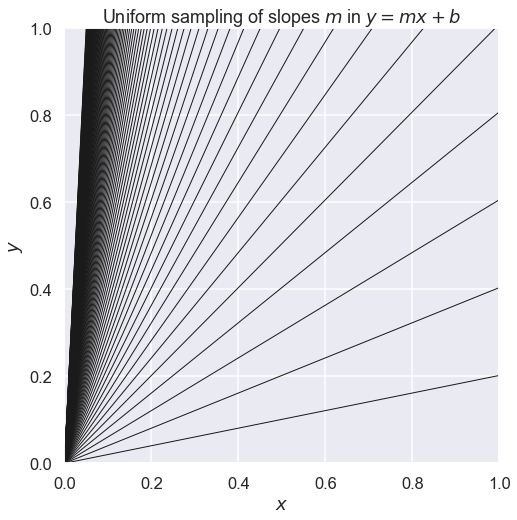

In [6]:
# see what happens if we sample from a uniform prior on the slope m
x_pts = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.axis([0., 1., 0., 1.])
for slope in np.linspace(0, 20, 100):   # 20 evenly spaced slopes m
    ax.plot(x_pts, slope * x_pts, '-k', linewidth=1)
ax.set_xlabel(r'$x$')    
ax.set_ylabel(r'$y$')    
ax.set_title(r'Uniform sampling of slopes $m$ in $y= mx + b$')
ax.set_aspect(1)


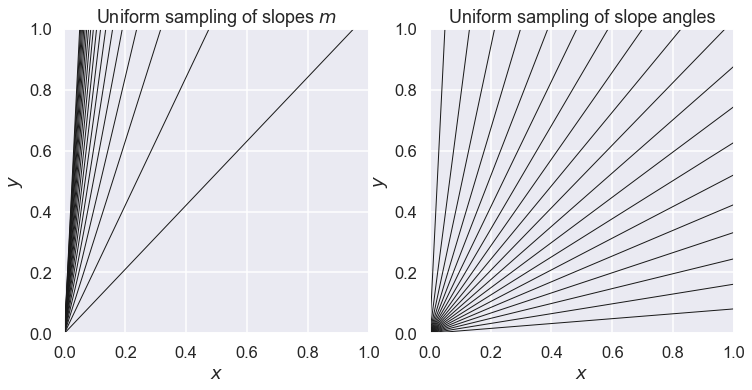

In [7]:
# compare with uniform sampling from the slope angle (20 samples)
x_pts = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis([0., 1., 0., 1.])
for slope in np.linspace(0, 20, num=20):   # 20 evenly spaced slopes m
    ax1.plot(x_pts, slope * x_pts, '-k', linewidth=1)
ax1.set_title(r'Uniform sampling of slopes $m$')

ax2 = fig.add_subplot(1, 2, 2)
ax2.axis([0., 1., 0., 1.])
for slopeAngle in np.linspace(0, np.arctan(20),num=20):   # 20 evenly spaced slope angles
    slope = np.tan(slopeAngle)
    ax2.plot(x_pts, slope * x_pts, '-k', linewidth=1)
ax2.set_title(r'Uniform sampling of slope angles')

for ax in [ax1,ax2]:
    ax.set_xlabel(r'$x$')    
    ax.set_ylabel(r'$y$')    
    ax.set_aspect(1)


In [8]:
def log_flat_prior(theta):
    if np.all(np.abs(theta) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_symmetric_prior(theta):
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)

In [9]:
# Write your code here

In [10]:
def contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior"""
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997])**2)
    return np.sort(sorted_[cutoffs])

In [11]:
def plot_results(x, y, dy,
                 slope_limits=(0.3, 0.7),
                 intercept_limits=(15, 35)):
    # 1. Evaluate the log probability on the grid (once for each prior)
    slope_range = np.linspace(*slope_limits)
    intercept_range = np.linspace(*intercept_limits)

    log_P1 = [[log_likelihood([b, m], x, y, dy) + log_flat_prior([b, m])
               for m in slope_range] for b in intercept_range]
    log_P2 = [[log_likelihood([b, m], x, y, dy) + log_symmetric_prior([b, m])
               for m in slope_range] for b in intercept_range]

    # For convenience, we normalize the pdf such that the maximum is 1
    P1 = np.exp(log_P1 - np.max(log_P1))
    P2 = np.exp(log_P2 - np.max(log_P2))

    # 2. Create two subplots and plot contours showing the results
    fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                           sharex=True, sharey=True)
    
    ax[0].contourf(slope_range, intercept_range, P1, 100, cmap='Blues')
    ax[0].contour(slope_range, intercept_range, P1, contour_levels(P1), 
                  colors='black')
    ax[0].set_title('Flat Prior')

    ax[1].contourf(slope_range, intercept_range, P2, 100, cmap='Blues')
    ax[1].contour(slope_range, intercept_range, P2, contour_levels(P2), 
                  colors='black')
    ax[1].set_title('Symmetric Prior')

    # 3. Add grids and set axis labels
    for axi in ax:
        axi.grid('on', linestyle=':', color='gray', alpha=0.5)
        axi.set_axisbelow(False)
        axi.set_xlabel('slope')
        axi.set_ylabel('intercept')
        
    # Return the figure and axes handles
    return fig, ax

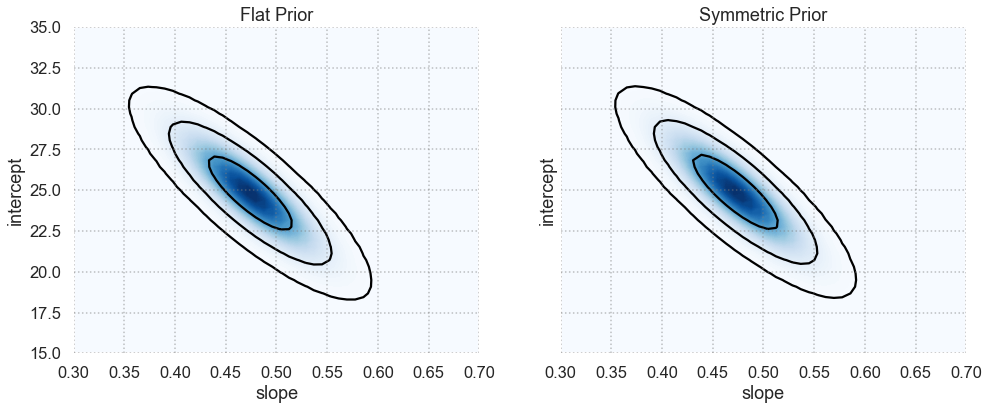

In [12]:
fig, ax = plot_results(x, y, dy)

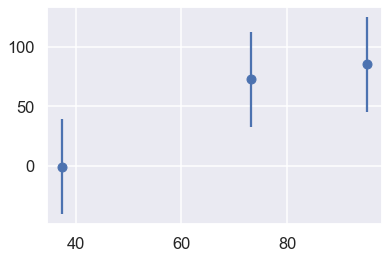

In [13]:
x2, y2, dy2 = make_data(*theta_true, N=3, dy=40)
plt.errorbar(x2, y2, dy2, fmt='o');

In [14]:
# Write your code here

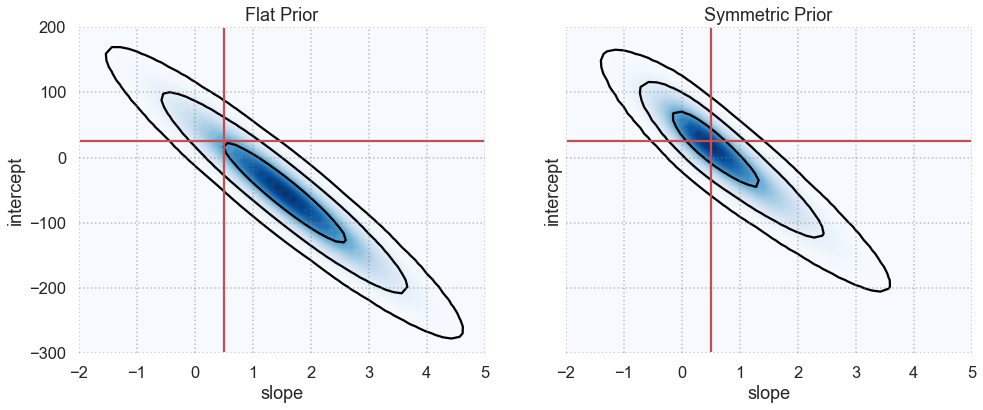

In [15]:
fig, axs = plot_results(x2, y2, dy2,
             slope_limits=(-2, 5),
             intercept_limits=(-300, 200))

for ax in axs:
    ax.axhline(theta_true[0],color='r')
    ax.axvline(theta_true[1],color='r')